In [8]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pybullet as p
import pybullet_data
import time
import matplotlib.pyplot as plt
from types import SimpleNamespace

import torch
import torch.nn as nn
import torch.nn.functional as F
import random

import import_ipynb
from hmanouch_christjo_dqn_pybullet import dqn_rewards
from hmanouch_christjo_ddqn_pybullet import ddqn_rewards
from hmanouch_christjo_per_dqn_pybullet import per_rewards
from hmanouch_christjo_dueling_dqn_pybullet import duel_rewards

## Defining the PyBullet GUI with the Robot arm and Object

In [2]:
# Connect to PyBullet and set up the environment

p.connect(p.GUI)
# p.connect(p.DIRECT)
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Load the KUKA robot and environment objects
planeId = p.loadURDF("plane.urdf")
cuboid_green_id = p.loadURDF("./object/block.urdf", [0.54, 0, 0.02], [0, 0, 0, 1])
kuka_id = p.loadURDF("kuka_iiwa/kuka_with_prismatic_gripper.urdf")

p.setGravity(0, 0, -10)
p.resetDebugVisualizerCamera(
    cameraDistance=2.0,    
    cameraYaw=75,         
    cameraPitch=-40,      
    cameraTargetPosition=[0, 0, 0]  
)

numJoints = p.getNumJoints(kuka_id)  

joints = {}

# Populate the joints dictionary with information about each joint
for joint_index in range(numJoints):
    joint_info = p.getJointInfo(kuka_id, joint_index)
    joint_name = joint_info[1].decode("utf-8")
    joints[joint_name] = SimpleNamespace(
        id=joint_info[0],
        lowerLimit=joint_info[8],
        upperLimit=joint_info[9],
        maxForce=joint_info[10],
        maxVelocity=joint_info[11],
    )

## Defining the Environment

In [3]:
class BulletKukaEnvironment(gym.Env):
    def __init__(self, gui=True):
        self.sim_time_step = 1 / 60
        self.eff_index = 7
        self.home_kuka_joint_angle = np.array([0.0] * 7)
        self.init_kuka_joint_angle = np.array([-0., 0.44, 0., -2.086, -0., 0.615, -0.])
        self.previous_eef_pos = None
        self.tilt_threshold = 0.5

        self.action_space = spaces.Discrete(2)  # 0: xPlus, 1: xMinus
        self.observation_space = spaces.Box(low=np.array([0.0, -np.pi]), high=np.array([1.0, np.pi]), dtype=np.float32)

        self.step_count = 0
        self.max_steps = 20

    def reset(self):
        self.set_kuka_joint_angles(self.home_kuka_joint_angle, self.init_kuka_joint_angle, duration=1)
        self.operate_gripper(init_pos=0., fin_pos=0.01, duration=1)  #  Open gripper
        p.resetBasePositionAndOrientation(cuboid_green_id, [0.54, 0, 0.02], [0, 0, 0, 1])

        eef_pos, _ = self.get_current_eef_pose()
        self.previous_eef_pos = eef_pos
        
        self.step_count = 0
        self.grasp_attempts = 0
        
        eef_pos, _ = self.get_current_eef_pose()
        obj_tilt = self.get_object_state(cuboid_green_id)[1]
        obs = np.array([eef_pos[0], obj_tilt], dtype=np.float32)
        return obs

    def calculate_ik(self, position, orientation):
        quaternion = p.getQuaternionFromEuler(orientation)
        lower_limits = [-np.pi] * 7
        upper_limits = [np.pi] * 7
        joint_ranges = [2 * np.pi] * 7
        rest_poses = [(-0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0)]  # Rest pose for 7 DOF
        # Calculate inverse kinematics with a 7-element damping vector
        joint_angles = p.calculateInverseKinematics(
            kuka_id, self.eff_index, position, quaternion,
            jointDamping=[0.01] * 7,
            lowerLimits=lower_limits,
            upperLimits=upper_limits,
            jointRanges=joint_ranges,
            restPoses=rest_poses
        )
        return joint_angles

    def set_kuka_joint_angles(self, init_joint_angles, des_joint_angles, duration):
        control_joints = ["lbr_iiwa_joint_1", "lbr_iiwa_joint_2", "lbr_iiwa_joint_3",
                        "lbr_iiwa_joint_4", "lbr_iiwa_joint_5", "lbr_iiwa_joint_6",
                        "lbr_iiwa_joint_7"]
        poses = []
        indexes = []
        forces = []
        for i, name in enumerate(control_joints):
            joint = joints[name]
            poses.append(des_joint_angles[i])
            indexes.append(joint.id)
            forces.append(joint.maxForce)
        trajectory = self.interpolate_trajectory(init_joint_angles, des_joint_angles, duration)
        for q_t in trajectory:
            p.setJointMotorControlArray(
                kuka_id, indexes,
                controlMode=p.POSITION_CONTROL,
                targetPositions=q_t,
                forces=forces
            )
            p.stepSimulation()
            time.sleep(self.sim_time_step)

    def position_path(self, t, t_max, start_pos, end_pos):
        return start_pos + (end_pos - start_pos) * (t / t_max)

    def orientation_path(self, t, t_max, start_orient, end_orient):
        """Orientation path (Euler angles)."""
        return start_orient + (end_orient - start_orient) * (t / t_max)

    def get_current_eef_pose(self):
        linkstate = p.getLinkState(kuka_id, self.eff_index, computeForwardKinematics=True)
        position, orientation = linkstate[0], linkstate[1]
        position = list(position)
        position[2] = position[2] - 0.0491
        return (position, list(p.getEulerFromQuaternion(orientation)))

    def get_current_joint_angles(self, kuka_or_gripper=None):
        joint_states = p.getJointStates(kuka_id, list(range(numJoints)))
        joint_values = [state[0] for state in joint_states]
        if kuka_or_gripper == 'kuka':
            return joint_values[:7]  # First 7 joints for the KUKA arm
        elif kuka_or_gripper == 'gripper':
            return joint_values[7:]  # Remaining joints for the gripper
        else:
            return joint_values

    def interpolate_trajectory(self, q_start, q_end, duration):
        num_steps = int(duration / self.sim_time_step) + 1
        trajectory = []
        for t in range(num_steps):
            alpha = t / (num_steps - 1)
            q_t = [q_start[i] + alpha * (q_end[i] - q_start[i]) for i in range(len(q_start))]
            trajectory.append(q_t)
        return trajectory

    def moveL(self, start_pos, end_pos, target_ori, duration):
        """
        Moves the robot's end-effector in a straight line from start_pos to end_pos.
        """
        num_steps = int(duration / self.sim_time_step) + 1
        target_quat = p.getQuaternionFromEuler(target_ori)
        for step in range(num_steps):
            alpha = step / (num_steps - 1)
            current_pos = np.array(start_pos) + alpha * (np.array(end_pos) - np.array(start_pos))
            
            if current_pos[2] < 0.05:  
                current_pos[2] = 0.05
            
            joint_poses = p.calculateInverseKinematics(kuka_id, self.eff_index, current_pos.tolist(), target_quat)
            control_joint_indices = list(range(7))
            target_positions = joint_poses[:7]
            p.setJointMotorControlArray(kuka_id, control_joint_indices,
                                        controlMode=p.POSITION_CONTROL,
                                        targetPositions=target_positions)
            p.stepSimulation()
            time.sleep(self.sim_time_step)

    def execute_task_space_trajectory(self, start_pos, final_pos, duration=1):
        all_joint_angles = self.calculate_ik(final_pos[0], final_pos[1])
        des_kuka_joint_angles = all_joint_angles[:7]
        self.set_kuka_joint_angles(self.get_current_joint_angles("kuka"), des_kuka_joint_angles, duration)

    def operate_gripper(self, init_pos, fin_pos, duration=1):
        """
        Smoothly open or close the gripper by interpolating the gripper opening angle.
        """
        control_joints = ["left_finger_sliding_joint", "right_finger_sliding_joint"]
        poses = []
        indexes = []
        forces = []
        
        init_arr = np.array([-init_pos, init_pos])
        fin_arr = np.array([-fin_pos, fin_pos])
        for i, name in enumerate(control_joints):
            joint = joints[name]
            poses.append(fin_arr[i])
            indexes.append(joint.id)
            forces.append(joint.maxForce)
        trajectory = self.interpolate_trajectory(init_arr, fin_arr, duration)
        for q_t in trajectory:
            p.setJointMotorControlArray(
                kuka_id, indexes,
                controlMode=p.POSITION_CONTROL,
                targetPositions=q_t,
                forces=forces
            )
            p.stepSimulation()
            time.sleep(self.sim_time_step)

    def get_object_state(self, object_id):
        position, orientation = p.getBasePositionAndOrientation(object_id)
        orientation_euler = p.getEulerFromQuaternion(orientation)
        return orientation_euler
    

    def execute_grip_action(self):
        """ 
        Move the gripper down, grip the object, lift it up and put it down again, 
        finally bring the gripper up to its initial position.
        """

        current_eef_pos, current_eef_orien = self.get_current_eef_pose()
        next_eef_pos = current_eef_pos.copy()
        # next_eef_pos[2] = next_eef_pos[2] - 0.1225

        obj_pos, _ = p.getBasePositionAndOrientation(cuboid_green_id)
        next_eef_pos[2] = obj_pos[2] + 0.02

        self.moveL(current_eef_pos, next_eef_pos, current_eef_orien, duration=1)
        self.operate_gripper(init_pos=0.01, fin_pos=0.00001, duration=0.5)  # Close gripper
        self.moveL(next_eef_pos, current_eef_pos, current_eef_orien, duration=1)
        obj_tilt_angle = self.get_object_state(cuboid_green_id)[1]
        self.moveL(current_eef_pos, next_eef_pos, current_eef_orien, duration=1)
        self.operate_gripper(init_pos=0., fin_pos=0.01, duration=1)  # Open gripper
        self.moveL(next_eef_pos, current_eef_pos, current_eef_orien, duration=1)

        return obj_tilt_angle
    

    def step(self, action):
        self.step_count += 1

        x_step = 0.05
        current_eef_pos, current_eef_orien = self.get_current_eef_pose()

        if hasattr(self, 'previous_eef_pos'):
            previous_eef_pos = self.previous_eef_pos
        else:
            previous_eef_pos = current_eef_pos
        
        next_eef_pos = current_eef_pos.copy()

        if action == 0:  # xPlus
            next_eef_pos[0] += x_step
        elif action == 1:  # xMinus
            next_eef_pos[0] -= x_step

        self.moveL(current_eef_pos, next_eef_pos, current_eef_orien, duration=2)

        # Check if the robot has actually moved
        post_move_pos, _ = self.get_current_eef_pose()
        movement_distance = np.linalg.norm(np.array(post_move_pos) - np.array(current_eef_pos))
        self.previous_eef_pos = post_move_pos  
        
        # Cheking if the robot is stuck
        if movement_distance < 0.05:  
            obs = np.array([post_move_pos[0], 0], dtype=np.float32)
            return obs, -3.0, False, {"stuck": True}

        # Find object tilt angle
        tilt = self.execute_grip_action()

        obj_pos, _ = p.getBasePositionAndOrientation(cuboid_green_id)
        
        # Create observation
        obs = np.array([next_eef_pos[0], tilt], dtype=np.float32)

        # Calculate rewards
        tilt_penalty = abs(tilt) * 5
        height_reward = max(0, obj_pos[2] - 0.05) * 10  
        position_reward = -abs(next_eef_pos[0] - 0.5) * 2

        # Calculate total reward
        reward = height_reward - tilt_penalty + position_reward 

        # Success if object is lifted with minimal tilt
        success = (abs(tilt) <= self.tilt_threshold)
        if success:
            reward += 10 
        else:
            reward -= 2
    
        terminated = (self.step_count >= self.max_steps)
        
        if success:
            terminated = True
        

        info = {
            "tilt_angle": tilt,
            "obj_height": obj_pos[2],
            "success": success
        }

        return obs, reward, terminated, info

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

In [5]:
env = BulletKukaEnvironment()
agent = NeuralNetwork(2,2)
agent.load_state_dict(torch.load('robot_arm_per_ddqn.pth', weights_only=True))
agent.eval()

NeuralNetwork(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

## Testing the models for 3 episodes

In [6]:
for _ in range(3):
    obs = env.reset()  
    total_reward = 0

    obs_tensor = torch.tensor([obs], dtype=torch.float32).unsqueeze(0) 
    
    for _ in range(20):
        q_values = agent(obs_tensor)  
        
        action = torch.argmax(q_values).item()

        obs, reward, terminated, _ = env.step(action)
        
        total_reward += reward
        obs_tensor = torch.tensor([obs], dtype=torch.float32).unsqueeze(0)

        if terminated:
            break  

    print(f"Total reward for the episode: {total_reward}")


Total reward for the episode: 3.463929335450924
Total reward for the episode: 3.4638714073944374
Total reward for the episode: 3.463871465235693


## Average rewards for each DQN Algorithm

In [7]:
print(np.mean(dqn_rewards))
print(np.mean(ddqn_rewards))
print(np.mean(per_rewards))
print(np.mean(duel_rewards))

-4.307643899258718
-4.863814759544428
-3.9995360935375857
-2.3484177990333714


## Comparison of Rewards per Episode for all DQN Algorithms

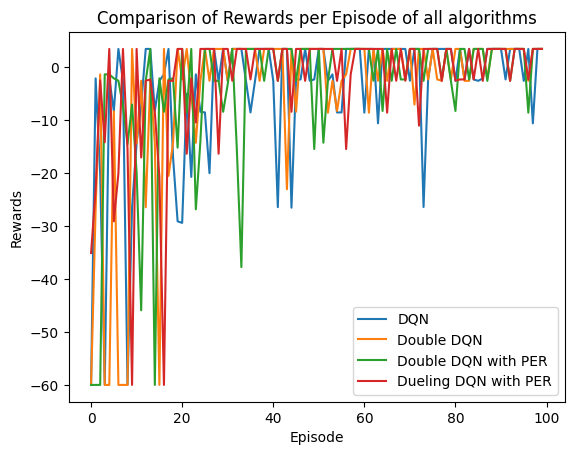

In [10]:
plt.plot(dqn_rewards, label="DQN")
plt.plot(ddqn_rewards, label="Double DQN")
plt.plot(per_rewards, label="Double DQN with PER")
plt.plot(duel_rewards, label="Dueling DQN with PER")
plt.title("Comparison of Rewards per Episode of all algorithms")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.show()